# Is it a wolf or is it snow? Using the LIME algorithm to invsitigate the decision making process of a deep learning model

- toc: true 
- badges: true
- comments: true
- categories: [XAI, LIME]

In 2016 Marco Riberio et al. proposed a new method for explaining AI models named LIME. Abbreviation LIME stands for Local Interpretable Model-Agnostic Explanations. The algorithm is capable of explaining any type of machine-learning model (that's why it is called "model agnostic) and works well with tabular, language, and image data. 

The LIME algorithm is available in the form of a python package, its code can be found on the Github at https://github.com/marcotcr/lime 

In this tutorial, we will show how LIME can be applied to investigate the deep learning model behavior. We will show that despite the model achieving good accuracy on a validation set it actually doesn't work. Such behavior is caused by a biased dataset and may cause real harm when the model is used for real-world applications. It may be especially dangerous in the case of medical imagining where it is nearly impossible for a non-medical professional to say whether or not the analyzed dataset of x-ray images is somehow biased. 

The proposed pet dataset contains two classes: Huskies and Wolves. The gathered data are intentionally biased - wolfs are always presented in a winter background with snow around them, while husky stand or lay on the grass. Even though it sounds obvious that such a dataset may cause a model to not perform well, it is still not so easy to spot this fact at a first glance, without having the prior knowledge about what is wrong. Riberio et al. gave such a dataset to the group of graduate students and only a minority of them spot the problem. Most of the students trusted the model based only on the accuracy metric. 

The train set consists of 50 images of huskies and 50 images of wolfs. The validation set contains 5 images of huskies and 5 images of wolfs. In the validation set 8 images to come from a similar domain as the training set (a husky on the grass, a wolf in the snow) while in the case of two we intentionally changed the usual background (husky on the snow and wolf on the grass). 

In this tutorial, we first train the torch model (resnet50) on the dataset, and then we use LIME to see which part of the image had the most significant contrubution to such prediction. The intuition behind is: if the model "looks" at the irrelevant part of the image then even if it is highly accurate on the validation set it probably doesn't work properly. The reason for that might be a biased dataset. In this case (wolf and husks) is relatively easy even for a layman to spot a problem, however, for a more complicated task (eg. classification of tumors on the images), it may be a highly complicated problem requiring lots of research and domain knowledge.

## Imports

In [1]:
from os import listdir
from os.path import join
from torchvision import transforms

import torch
from torch.optim import lr_scheduler
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import pytorch_lightning as pl

import albumentations as A
from albumentations.pytorch import ToTensorV2

from skimage.segmentation import mark_boundaries
from lime import lime_image

from lime_image.dataset import HuskyWolfDataset
from lime_image.datamodule import HuskyWolfDataModule

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image


from sklearn.metrics import accuracy_score

# Data Visualisation 

In order to get some intuition about how the data looks like let us visualize a few examples from both test and validations sets

## Directories with gathered datasets

In [2]:
husky_train_path = join("lime_image", "husky_train")
wolf_train_path = join("lime_image", "wolf_train")

husky_test_path = join("lime_image", "husky_test")
wolf_test_path = join("lime_image", "wolf_test")

## Husky train

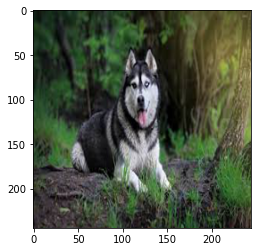

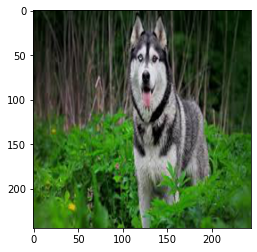

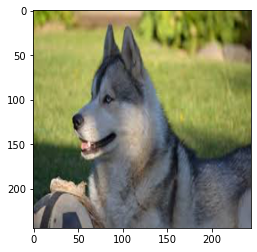

In [3]:
files = [(join(husky_train_path, file)) for file in listdir(husky_train_path)]

imshow(Image.open(files[0]).resize((244, 244)))
plt.show()

imshow(Image.open(files[1]).resize((244, 244)))
plt.show()

imshow(Image.open(files[2]).resize((244, 244)))
plt.show()

## Husky test

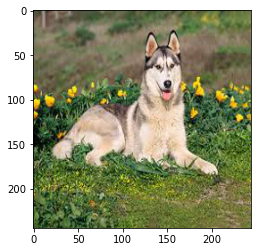

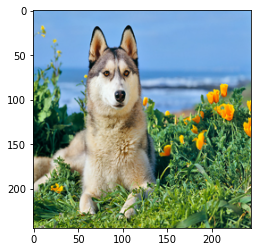

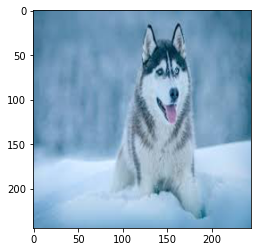

In [4]:
files = [(join(husky_test_path, file)) for file in listdir(husky_test_path)]

imshow(Image.open(files[0]).resize((244, 244)))
plt.show()

imshow(Image.open(files[1]).resize((244, 244)))
plt.show()

imshow(Image.open(files[4]).resize((244, 244)))
plt.show()

## Wofl train

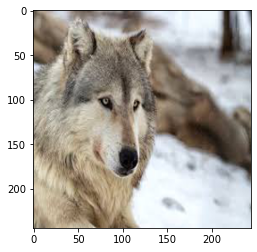

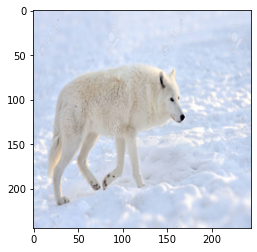

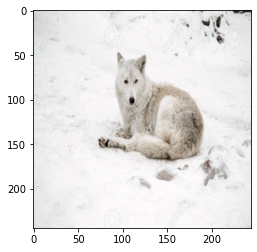

In [5]:
files = [(join(wolf_train_path, file)) for file in listdir(wolf_train_path)]

imshow(Image.open(files[0]).resize((244, 244)))
plt.show()

imshow(Image.open(files[1]).resize((244, 244)))
plt.show()

imshow(Image.open(files[2]).resize((244, 244)))
plt.show()

## Wofl test

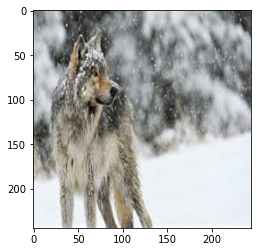

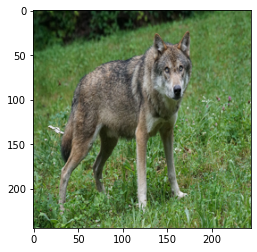

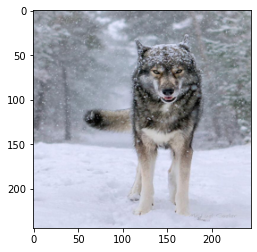

In [6]:
files = [(join(wolf_test_path, file)) for file in listdir(wolf_test_path)]

imshow(Image.open(files[0]).resize((244, 244)))
plt.show()

imshow(Image.open(files[1]).resize((244, 244)))
plt.show()

imshow(Image.open(files[2]).resize((244, 244)))
plt.show()

# Training the model

## Define the model

As a base model, we will use resnet50. We will train it using PyTorch Lighting. Since our dataset is relatively small we will use the transfer learning technique and train only the last layer.

In [7]:
class WolfHuskyClassifier(pl.LightningModule):
    def __init__(self):
        super(WolfHuskyClassifier, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        
        self.model = models.resnet50(pretrained=True)
        
        ## Only the last layer is trained
        for p in self.model.parameters():
            p.requires_grad = False

        self.num_ftrs = self.model.fc.in_features
        self.number_of_classes = 2
        self.model.fc = nn.Linear(self.num_ftrs, self.number_of_classes)
    
    
    def forward(self, x):
        return self.model(x)

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        return [optimizer], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        
        tensorboard_logs = {'train_loss': loss}
        
        return {'loss': loss, 'log': tensorboard_logs}

    
    def validation_step(self, batch, batch_idx):
        x, y = batch

        logits = self.forward(x)
        loss = self.criterion(logits, y)
        
        return {"val_loss": loss}
        
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        
        tensorboard_logs = {"val_loss" : avg_loss}

        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

## Image augmentations

To artificially extend the dataset we will use random image transformations. To make it more "understandable" for a model we have to normalize it (we use standard ImageNet mean and std parameters).

In [8]:
val_transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
            ])

In [9]:
train_transform = A.Compose([
            A.Resize(400, 400),
            A.RandomCrop(224, 224),
            A.HorizontalFlip(),
            A.RandomRotate90(),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
            A.Blur(blur_limit=3),
            A.OpticalDistortion(),
            A.GridDistortion(),
            A.HueSaturationValue(),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2()
        ])

## Start training

In [10]:
pl.seed_everything(42)

dm = HuskyWolfDataModule(2, train_transform, val_transform)

model = WolfHuskyClassifier()

trainer = pl.Trainer(max_epochs=20,
                  gpus=0,
                  accumulate_grad_batches=4,
                  deterministic=True,
                  early_stop_callback=True,
                  )

trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23 M  


Saving latest checkpoint..
Epoch 00015: early stopping triggered.


1

## Check the model performance

In [11]:
wolf_husky_trainset = HuskyWolfDataset([husky_train_path, wolf_train_path], val_transform)
wolf_husky_testset = HuskyWolfDataset([husky_test_path, wolf_test_path], val_transform)

In [12]:
model.eval()

y_pred = []
y_true = []
for img, label in wolf_husky_trainset:
    pred = torch.argmax(model(img.unsqueeze(0)))
    y_pred.append(pred)
    y_true.append(label)
    
print(f"Accuracy on train: {accuracy_score(y_true, y_pred)}")    
print()

wrong_preds = []

y_pred = []
y_true = []
for idx, (img, label) in enumerate(wolf_husky_testset):
    pred = torch.argmax(model(img.unsqueeze(0)))
      
    if pred != label:
        wrong_preds.append(idx)
        
    y_pred.append(pred)
    y_true.append(label)
      
print()      
print(f"Accuracy on validation: {accuracy_score(y_true, y_pred)}")
print()      
print(f"Wrong preds: {wrong_preds}")

Accuracy on train: 1.0


Accuracy on validation: 0.9090909090909091

Wrong preds: [6]


# Metrics seems accurate, but does the model actually perform well in the task it was designed for?

First lets check the example where model didn't gave us a correct prediction. To do so we will use the `LimeImageExplainer` from the `lime` package

In [13]:
label_to_class = {0 : "husky", 1 : "wolf"}

In [14]:
vanila_tranform = A.Compose([
            A.Resize(224, 224),
            ])

visualisation_testset = HuskyWolfDataset([husky_test_path, wolf_test_path], vanila_tranform)

investigated_img, real_label = visualisation_testset[wrong_preds[0]]

In [15]:
#collapse-hide
def get_preprocess_transform():
    "https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb"
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

preprocess_transform = get_preprocess_transform()

In [16]:
#collapse-hide
def batch_predict(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

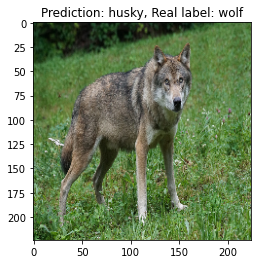

In [17]:
test_pred = batch_predict([investigated_img])

title = f"Prediction: {label_to_class[test_pred.squeeze().argmax()]}, Real label: {label_to_class[real_label.item()]}"

plt.title(title)
plt.imshow(investigated_img)

In [18]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
                                         investigated_img,
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000)

## Visualize the explaination

As we can see it was the background that contributed most to the prediction (the green field). Actually the relevant part - the body of the wolf, correctly "voted" against image be classified as a husky. Despite that, the contribution of grass was more significant and the image was classified incorrectly. 

Nevertheless, regardless of the final prediction, we can see that there is something inherently wrong about the model. It focuses itself on the irrelevant pieces of data and mostly ignores the relevant. It should be an alarming sound for any machine-learning practitioner that maybe something in the training process (presumably the data) is not correct. 

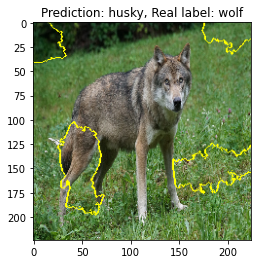

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)

plt.title(title)
plt.imshow(img_boundry1)

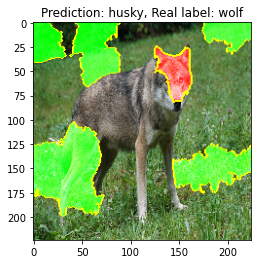

In [20]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)

plt.title(title)
plt.imshow(img_boundry2)

## Ok, how about explainations for another images

Let us take 5 examples both classified correctly and let's use LIME to see at what the trained model is "looking" in the decision-making process. 

Unsurprisingly in all cases, the background (grass/snow) has a significant impact on the outcome, which, as it was stated before should not be the case. On the other hand, we can see that our model is not totally useless. While making the decision, in some cases it still "looks" at the body of the animal, this can be a positive sing meaning that in case we provide the neural network with a less biased and more diverse data it might be able to classify the dataset correctly.

In [21]:
investigated_img_0, real_label_0 = visualisation_testset[5]
investigated_img_1, real_label_1 = visualisation_testset[0]
investigated_img_2, real_label_2 = visualisation_testset[3]
investigated_img_3, real_label_3 = visualisation_testset[7]
investigated_img_4, real_label_4 = visualisation_testset[9]

In [22]:
test_pred = batch_predict([investigated_img_0, investigated_img_1, investigated_img_2, investigated_img_3, investigated_img_4])
preds = test_pred.squeeze().argmax(axis=1)
print(f"Predictions: {preds}")
print(f"Real Labels: {real_label_0.item(), real_label_1.item(), real_label_2.item(), real_label_3.item(), real_label_4.item()}")

Predictions: [1 0 0 1 1]
Real Labels: (1, 0, 0, 1, 1)


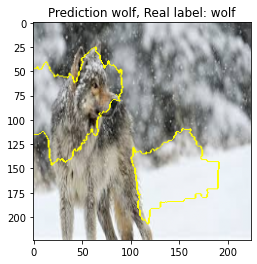

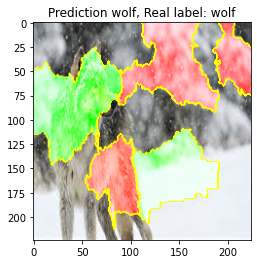

In [23]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
                                         investigated_img_0,
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)

title = f"Prediction {label_to_class[preds[0]]}, Real label: {label_to_class[real_label_0.item()]}"

plt.title(title)
plt.imshow(img_boundry1)
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)

plt.title(title)
plt.imshow(img_boundry2)

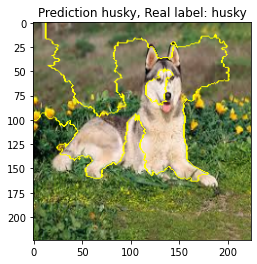

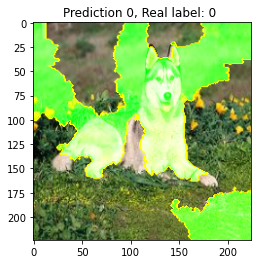

In [24]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
                                         investigated_img_1,
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)

title = f"Prediction {label_to_class[preds[1]]}, Real label: {label_to_class[real_label_1.item()]}"
plt.title(title)
plt.imshow(img_boundry1)
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)

plt.title(f"Prediction {preds[1]}, Real label: {real_label_1} ")
plt.imshow(img_boundry2)
plt.show()

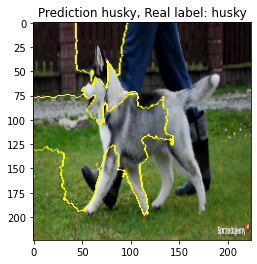

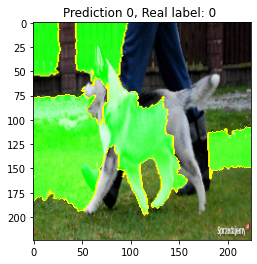

In [25]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
                                         investigated_img_2,
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)

title = f"Prediction {label_to_class[preds[2]]}, Real label: {label_to_class[real_label_2.item()]}"
plt.title(title)
plt.imshow(img_boundry1)
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)

plt.title(f"Prediction {preds[2]}, Real label: {real_label_2} ")
plt.imshow(img_boundry2)
plt.show()

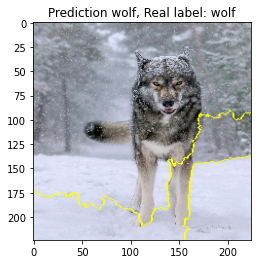

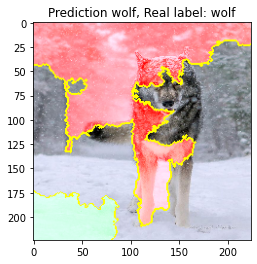

In [26]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
                                         investigated_img_3,
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)

title = f"Prediction {label_to_class[preds[3]]}, Real label: {label_to_class[real_label_3.item()]}"
plt.title(title)
plt.imshow(img_boundry1)
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)

plt.title(title)
plt.imshow(img_boundry2)
plt.show()

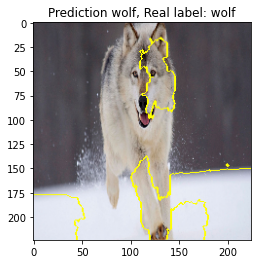

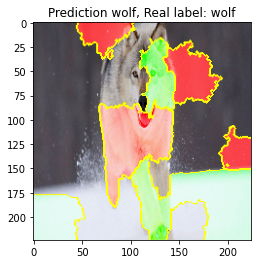

In [27]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
                                         investigated_img_4,
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)

title = f"Prediction {label_to_class[preds[4]]}, Real label: {label_to_class[real_label_4.item()]}"
plt.title(title)
plt.imshow(img_boundry1)
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)

plt.title(title)
plt.imshow(img_boundry2)
plt.show()

# Summary

We shown, how we can investigate the model performance using the LIME algorithm. A similar approach can be easily applied to tabular and language models as well. Using LIME gives the machine-learning practitioner a useful insight into the decision-making process of a model. 

Based on a given explanation and prior experience of a human expert we can determine whether or not the trained model actually does what it is supposed to be doing. This additional insight may help us in removing the unwanted biases from the dataset or in removing irrelevant features from tabular data. 

# Further Reading

I highly recommend the original work of Marco Riberio et al. It is available online at https://arxiv.org/abs/1602.04938

# And other sources

A video by Cristian Arteaga in which he implements LIME for images from scratch

https://www.youtube.com/watch?v=ENa-w65P1xM&feature=youtu.be 

The original video by Marco Riberio. The author doesn't explain the LIME in detail but rather gives the viewer an overview about why we should care about explainability

https://www.youtube.com/watch?v=KP7-JtFMLo4&feature=youtu.be

A presentation by Kasia Kulma which gives little bit more insights in the mechanism behind Lime

https://www.youtube.com/watch?v=CY3t11vuuOM&feature=youtu.be